In [1]:
import pickle, os, sys, math
import numpy as np
import pandas as pd
import seaborn as sns
from numpy import random
import matplotlib.pyplot as plt

PROJECT_DIR = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.insert(1, PROJECT_DIR)

from samples.data_sim import remove_feature
from city_pv_uni_modal import CityPV_UniModal
from city_pv_multi_modal import CityPV_MultiModal
from feature_selection import tune_pacf, rfecv_selection
from utils_pv import get_available_modules, get_available_inverters, visualize_pv, visualize_env
from samples.data_sim import PVDataset

random_seed = 3
random.seed(random_seed)
np.random.seed(random_seed)
random_state = np.random.RandomState(random_seed)


## Generating Data
### Train-Test Split
* only in March and April
* 15 years of data
* different training scenarios using 2 weeks, 1 year, 5 years, and 15 years of data for training
* always test on last week of March and last week of April

### Notes:
* 24 clients instead of 5
* reduced dev on azimuth
* added more variation in other parameters
* sml has 150 samples


In [4]:
exp_name = 'PV_UniModal'
num_clients = 24
city_names = ['Lausanne']
env_dict = {'city_names':city_names,
            'num_clients': num_clients, 'num_modes': len(city_names),
            'tilt_std': 5, 'az_std':15, 'weather_dev':0.1,
            'irrad_std':0.2, 'altitude_dev':0.1, 'shadow_peak_red':1,
            'module_name': ['Canadian_Solar_CS5P_220M___2009_'],
            'inverter_name': ['ABB__MICRO_0_25_I_OUTD_US_208__208V_'],
            'lags':[1, 2, 3, 4, 19, 23, 30], 
            'months':[3,4], 'hours':np.arange(7, 17), 
            'train_scenarios':{'sml':{'m_train':150, 'train_years':[2019], 'exclude_last_year':True},
                            '1y':{'m_train':None, 'train_years':[2019], 'exclude_last_year':True},
                            '5y':{'m_train':None, 'train_years':np.arange(2015, 2020), 'exclude_last_year':True},
                            }}
pvdataset = PVDataset(env_dict)
env_dict = pvdataset.generate_clients_data()
print('\n'+env_dict['info'])

for scenario_name in env_dict['train_scenarios'].keys():
    print(scenario_name + ' has {:3.0f} train and {:3.0f} validation samples'.format(
                    env_dict['train_scenarios'][scenario_name]['clients_data'][0][0].shape[0],
                    env_dict['train_scenarios'][scenario_name]['clients_data'][0][2].shape[0]))


non_ar_feat_keep = ['H_sun', 'station_irrad_direct_prev']
non_ar_feat_remove = [x for x in env_dict['feature_names'] if not ((x in non_ar_feat_keep) or x.startswith('lag'))]
for feature_name in non_ar_feat_remove:
    remove_feature(
        env_dict=env_dict, 
        feature_name=feature_name, in_place=True)

print('[INFO] {:2.0f} features: '.format(len(env_dict['feature_names'])), env_dict['feature_names'])


[INFO] generating data for Lausanne

24 households at Lausanne - tilt_std: 5.0, az_std: 15.0, weather_dev: 0.1, irrad_std: 0.2, altitude_dev: 0.1, shadow_peak_red: 1.0, same module_name, same inverter_name, 
sml has 150 train and 140 validation samples
1y has 610 train and 140 validation samples
5y has 3050 train and 140 validation samples
[INFO]  9 features:  ['H_sun', 'station_irrad_direct_prev', 'lag 1', 'lag 2', 'lag 3', 'lag 4', 'lag 19', 'lag 23', 'lag 30']


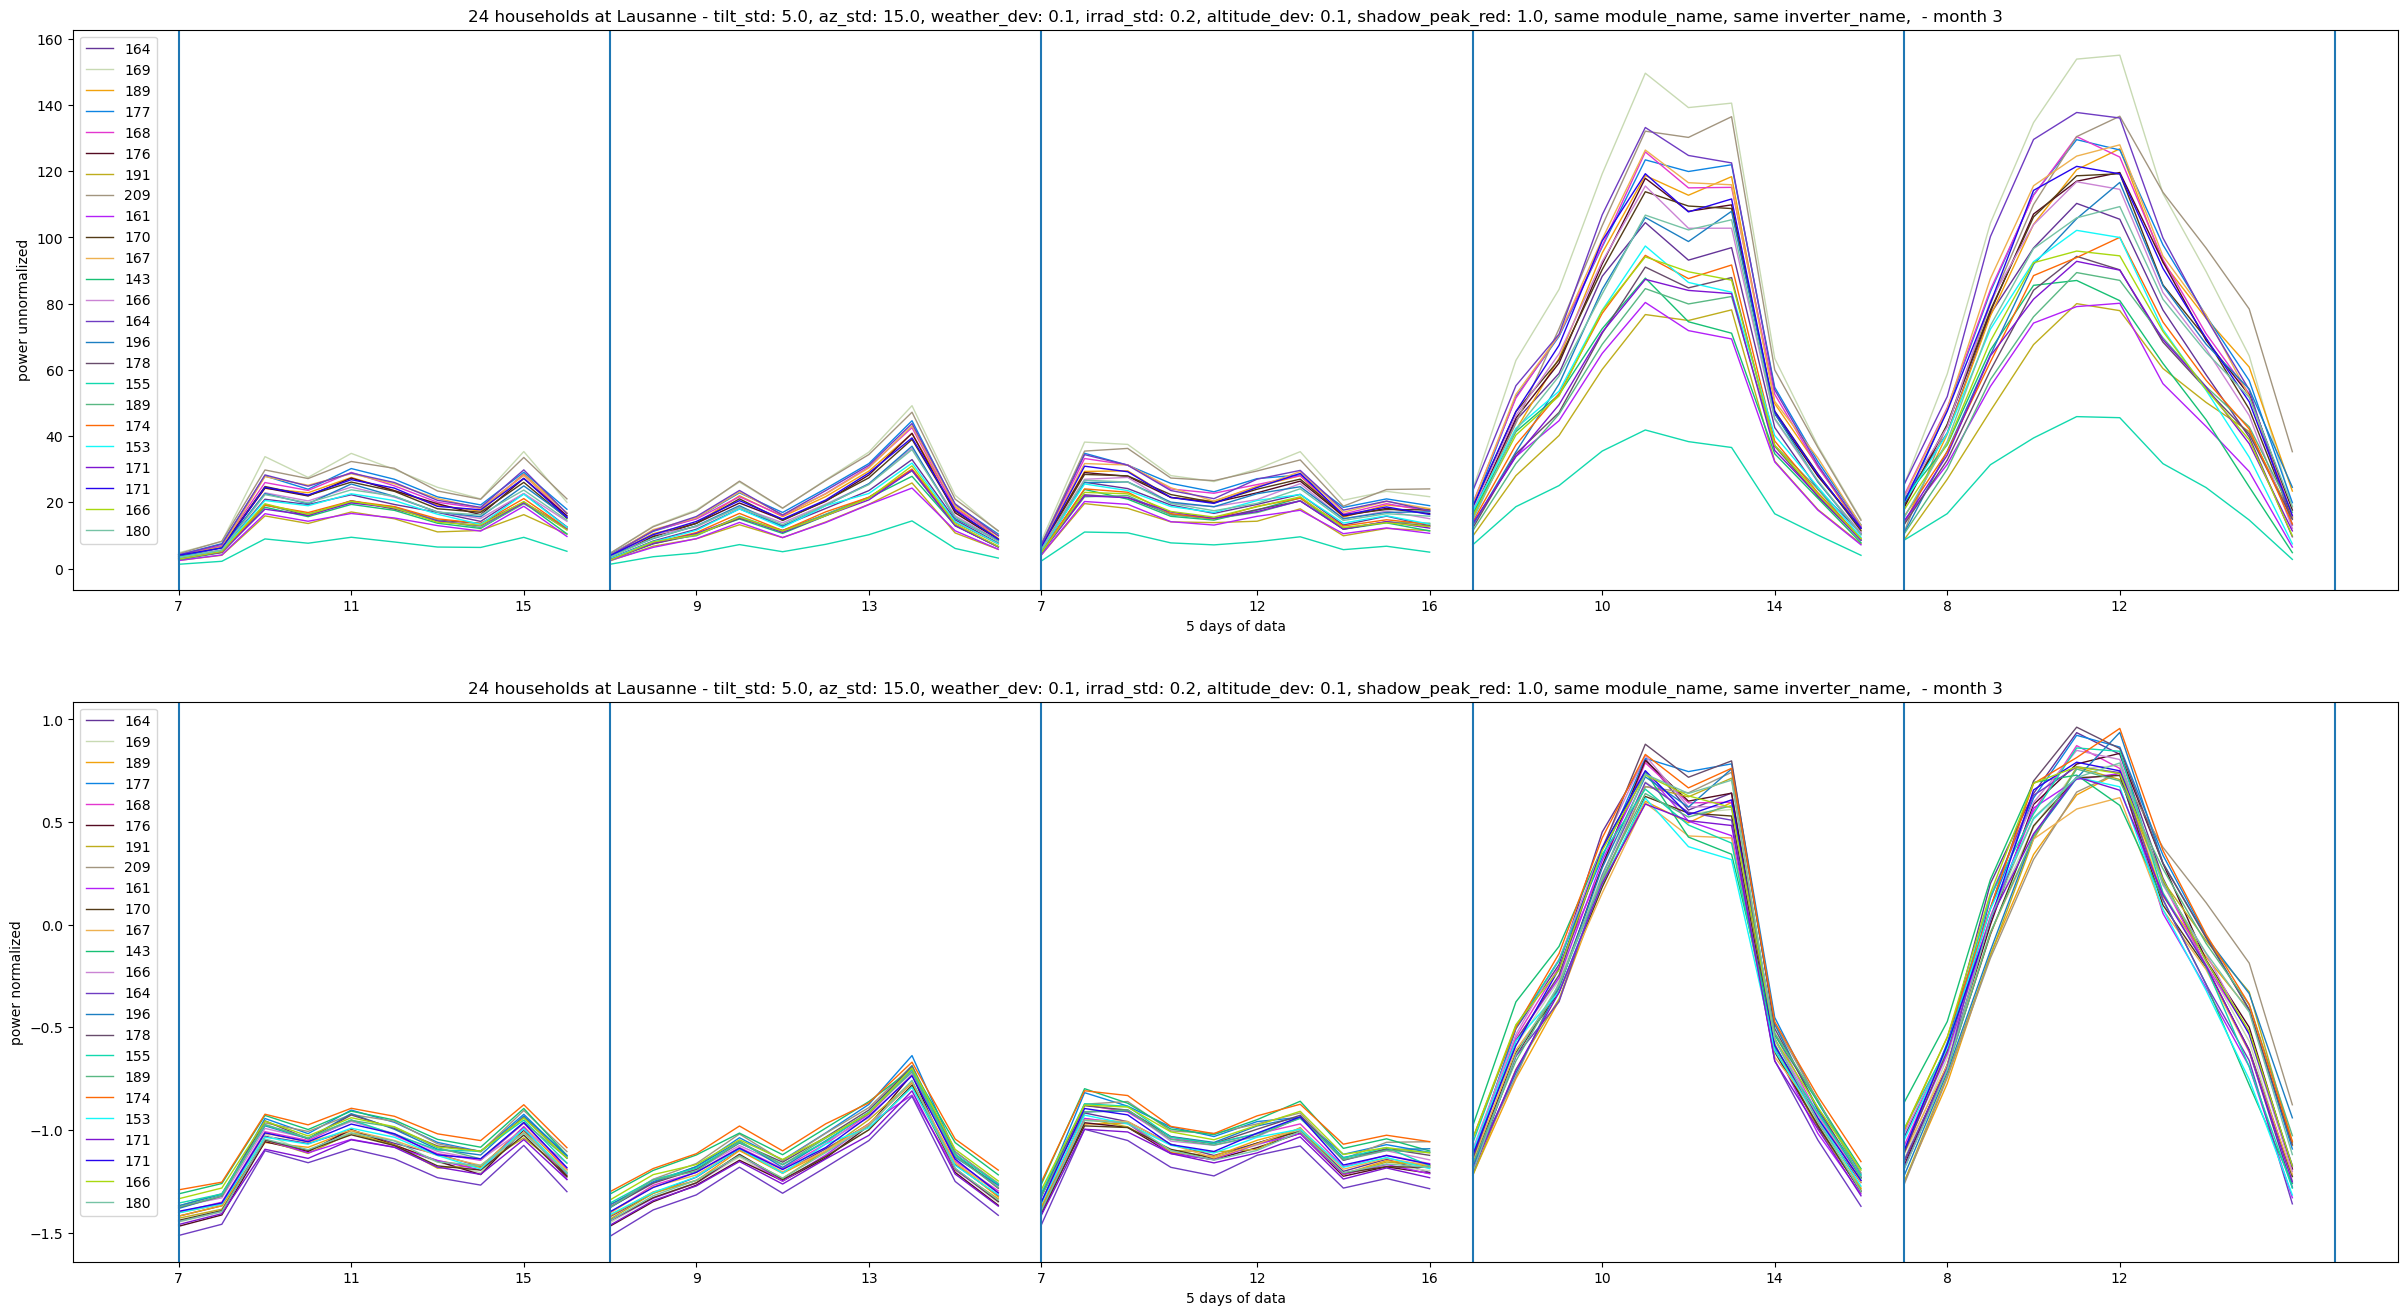

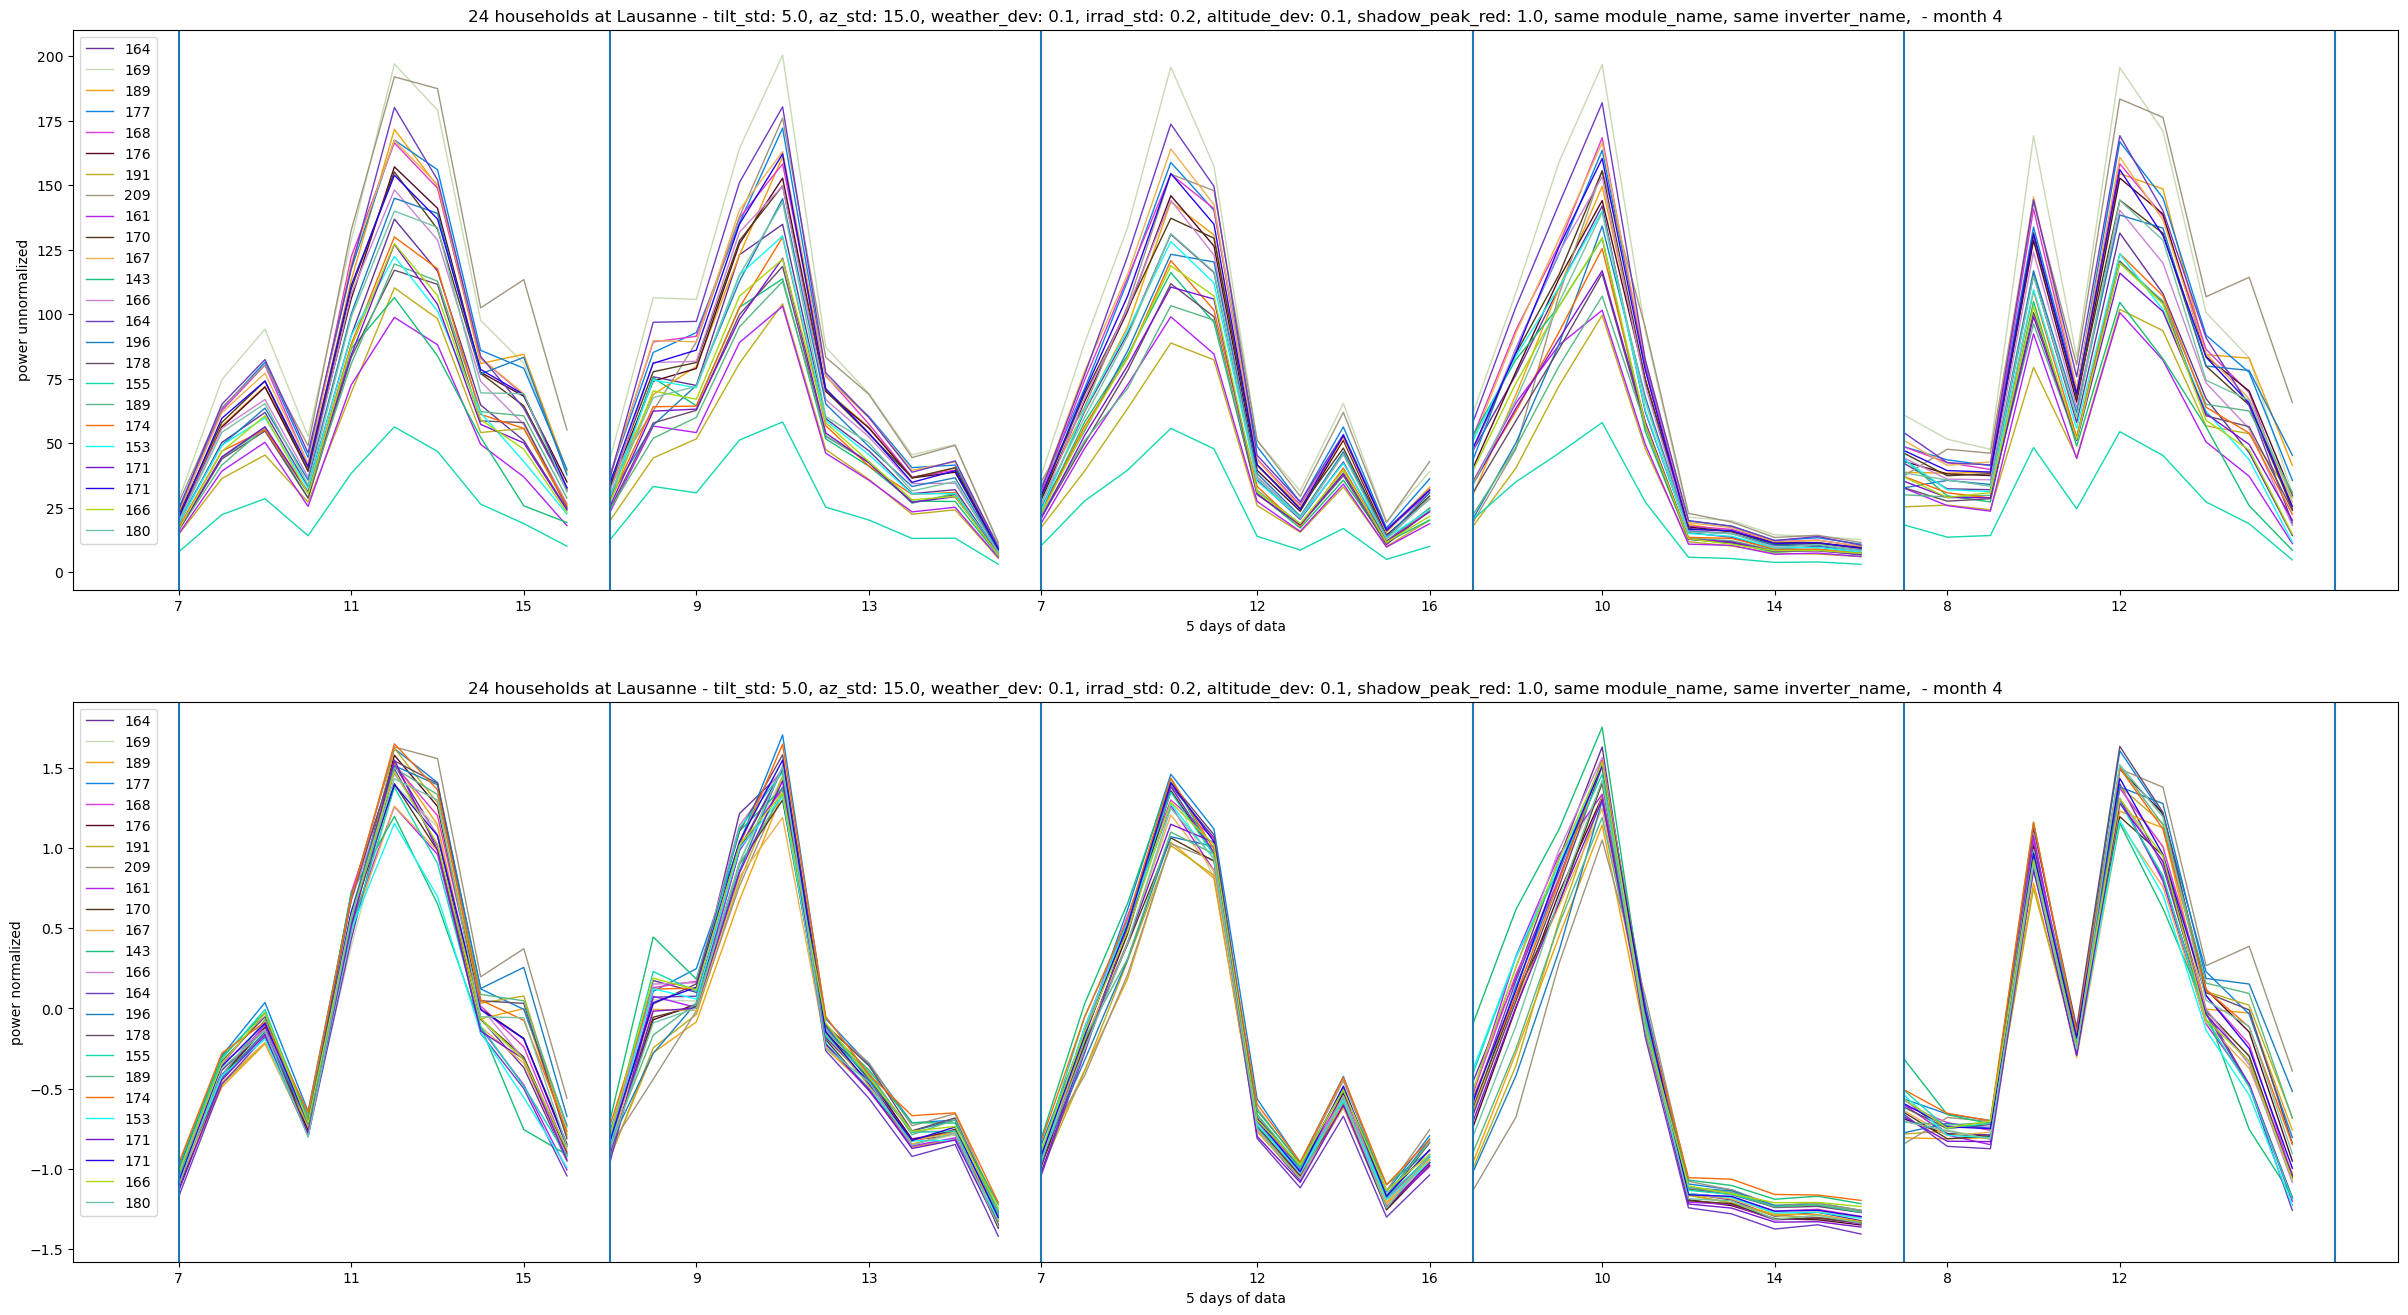

In [5]:
visualize_env(env_dict, num_days=5)

In [6]:
filename_env = os.getcwd() + "/../../saved_results/" + exp_name + "_nicolas_env_raw"
# save env
file = open(filename_env, 'wb')
pickle.dump(env_dict, file)
msg = '[INFO] saved data for {:2.0f} clients'.format(env_dict['num_clients'])

### NOTE
* I think it's better to use normalized data.
* For each client, we normalize both the features and the output.
* Normalization is done for both training and validation dataset using the mean and std of the "training data".
* Thus, all features and the output in the training data will have a zero mean and std of one. 
* In the validation set, the mean and std would not be exactly 0 and 1, but rather close to these values.

In [7]:
from utils_pv import normalize_data_tup

scenario_name = 'sml'
clients_data = env_dict['train_scenarios'][scenario_name]['clients_data']
clients_data_nrm = [None]*len(clients_data)
for client_num in np.arange(env_dict['num_clients']):
    clients_data_nrm[client_num], _, _ = normalize_data_tup(clients_data[client_num])

ImportError: cannot import name 'normalize_data_tup' from 'utils_pv' (/Users/mahrokh/DECODE/Simulations/Synthetic_PV_Profiles/utils_pv.py)